This is my revised kernel inspired by Chau Ngoc Huynh's kernel (3.699) and Panchajanya Banerjee's idea to include the holidays.

Adding these special days to the model, improved the model efficiency.

I am adding some new dates - that influence shopping season across Brazil. 
(Reference : http://thebrazilbusiness.com/article/shopping-seasons-in-brazil)

For 2017-18

1. Mother's Day : Second Sunday of May : May 13 2018
2. Father's Day : Second Sunday of August :  August 13 2017
3. Valentine's Day : 12th June, 2017
4. Children's Day : 12th October 2017
5. Black Friday : 24th November 2017
6. Christmas day : 25th December 2017


In [1]:
# Import the necessary libraries
import numpy as np
import pandas as pd
import os
import time
import warnings
import gc
import os
from six.moves import urllib
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('seaborn')
from scipy.stats import norm, skew
from sklearn.preprocessing import StandardScaler

In [2]:
#Add All the Models Libraries

# Scalers
from sklearn.utils import shuffle
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

# Models

from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_log_error,mean_squared_error, r2_score,mean_absolute_error

from sklearn.model_selection import train_test_split #training and testing data split
from sklearn import metrics #accuracy measure
from sklearn.metrics import confusion_matrix #for confusion matrix
from scipy.stats import reciprocal, uniform

from sklearn.model_selection import StratifiedKFold

# Cross-validation
from sklearn.model_selection import KFold #for K-fold cross validation
from sklearn.model_selection import cross_val_score #score evaluation
from sklearn.model_selection import cross_val_predict #prediction
from sklearn.model_selection import cross_validate

# GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

#Common data processors
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from scipy import sparse

In [3]:
# to make this notebook's output stable across runs
np.random.seed(123)
gc.collect()
# To plot pretty figures
%matplotlib inline
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [4]:
#Reduce the memory usage - Inspired by Panchajanya Banerjee
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [5]:
train = reduce_mem_usage(pd.read_csv('../input/train.csv',parse_dates=["first_active_month"]))
test = reduce_mem_usage(pd.read_csv('../input/test.csv', parse_dates=["first_active_month"]))

Mem. usage decreased to  4.04 Mb (56.2% reduction)
Mem. usage decreased to  2.24 Mb (52.5% reduction)


In [6]:
train.shape

(201917, 6)

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201917 entries, 0 to 201916
Data columns (total 6 columns):
first_active_month    201917 non-null datetime64[ns]
card_id               201917 non-null object
feature_1             201917 non-null int8
feature_2             201917 non-null int8
feature_3             201917 non-null int8
target                201917 non-null float16
dtypes: datetime64[ns](1), float16(1), int8(3), object(1)
memory usage: 4.0+ MB


In [8]:
# Now extract the month, year, day, weekday
train['days'] = (datetime.date(2018, 2, 1) - train['first_active_month'].dt.date).dt.days
train['quarter'] = train['first_active_month'].dt.quarter

test['days'] = (datetime.date(2018, 2, 1) - test['first_active_month'].dt.date).dt.days
test['quarter'] = test['first_active_month'].dt.quarter

Now we will try to extract more features from Transactions Data

In [9]:
# Taking Reference from Other Kernels
def aggregate_transaction_hist(trans, prefix):  
        
    agg_func = {
        'purchase_date' : ['max','min'],
        'month_diff' : ['mean', 'min', 'max', 'var'],
        'weekend' : ['sum', 'mean'],
        'authorized_flag': ['sum', 'mean'],
        'category_1': ['sum','mean', 'max','min'],
        'purchase_amount': ['sum', 'mean', 'max', 'min', 'std'],
        'installments': ['sum', 'mean', 'max', 'min', 'std'],  
        'month_lag': ['max','min','mean','var'],
        'card_id' : ['size'],
        'month': ['nunique'],
        'hour': ['nunique'],
        'quarter':['nunique'],
        'weekofyear': ['nunique'],
        'dayofweek': ['nunique'],
        'year': ['nunique'],
        'subsector_id': ['nunique'],
        'merchant_category_id' : ['nunique'],
        'Christmas_Day_2017':['mean'],
        'fathers_day_2017':['mean'],
        'Children_day_2017':['mean'],
        'Black_Friday_2017':['mean'],
        'Valentine_day_2017':['mean'],
        'Mothers_Day_2018':['mean']
    }
    
    agg_trans = trans.groupby(['card_id']).agg(agg_func)
    agg_trans.columns = [prefix + '_'.join(col).strip() 
                           for col in agg_trans.columns.values]
    agg_trans.reset_index(inplace=True)
    
    df = (trans.groupby('card_id')
          .size()
          .reset_index(name='{}transactions_count'.format(prefix)))
    
    agg_trans = pd.merge(df, agg_trans, on='card_id', how='left')
    
    return agg_trans

In [10]:
transactions = reduce_mem_usage(pd.read_csv('../input/historical_transactions.csv'))
transactions['authorized_flag'] = transactions['authorized_flag'].map({'Y': 1, 'N': 0})
transactions['category_1'] = transactions['category_1'].map({'Y': 1, 'N': 0})

Mem. usage decreased to 1749.11 Mb (43.7% reduction)


In [11]:
#Feature Engineering - Adding new features inspired by Chau's first kernel
transactions['purchase_date'] = pd.to_datetime(transactions['purchase_date'])
transactions['year'] = transactions['purchase_date'].dt.year
transactions['weekofyear'] = transactions['purchase_date'].dt.weekofyear
transactions['month'] = transactions['purchase_date'].dt.month
transactions['dayofweek'] = transactions['purchase_date'].dt.dayofweek
transactions['weekend'] = (transactions.purchase_date.dt.weekday >=5).astype(int)
transactions['hour'] = transactions['purchase_date'].dt.hour 
transactions['quarter'] = transactions['purchase_date'].dt.quarter
transactions['month_diff'] = ((datetime.datetime.today() - transactions['purchase_date']).dt.days)//30
transactions['month_diff'] += transactions['month_lag']

#impute missing values - This is now excluded.
transactions['category_2'] = transactions['category_2'].fillna(1.0,inplace=True)
transactions['category_3'] = transactions['category_3'].fillna('A',inplace=True)
transactions['merchant_id'] = transactions['merchant_id'].fillna('M_ID_00a6ca8a8a',inplace=True)

transactions['category_3'] = transactions['category_3'].map({'A':0, 'B':1, 'C':2})
gc.collect()

207

In [12]:
agg_func = {
        'mean': ['mean'],
    }
for col in ['category_2','category_3']:
    transactions[col+'_mean'] = transactions['purchase_amount'].groupby(transactions[col]).agg('mean')
    transactions[col+'_max'] = transactions['purchase_amount'].groupby(transactions[col]).agg('max')
    transactions[col+'_min'] = transactions['purchase_amount'].groupby(transactions[col]).agg('min')
    transactions[col+'_var'] = transactions['purchase_amount'].groupby(transactions[col]).agg('var')
    agg_func[col+'_mean'] = ['mean']

In [13]:
# New Features with Key Shopping times considered in the dataset. if the purchase has been made within 60 days, it is considered as an influence
#Christmas : December 25 2017
transactions['Christmas_Day_2017'] = (pd.to_datetime('2017-12-25') - transactions['purchase_date']).dt.days.apply(lambda x: x if x > 0 and x < 100 else 0)
#Mothers Day: May 14 2017
#transactions['Mothers_Day_2017'] = (pd.to_datetime('2017-05-04') - transactions['purchase_date']).dt.days.apply(lambda x: x if x > 0 and x < 100 else 0)
#fathers day: August 13 2017
transactions['fathers_day_2017'] = (pd.to_datetime('2017-08-13') - transactions['purchase_date']).dt.days.apply(lambda x: x if x > 0 and x < 100 else 0)
#Childrens day: October 12 2017
transactions['Children_day_2017'] = (pd.to_datetime('2017-10-12') - transactions['purchase_date']).dt.days.apply(lambda x: x if x > 0 and x < 100 else 0)
#Black Friday : 24th November 2017
transactions['Black_Friday_2017'] = (pd.to_datetime('2017-11-24') - transactions['purchase_date']).dt.days.apply(lambda x: x if x > 0 and x < 100 else 0)
#Valentines Day
transactions['Valentine_day_2017'] = (pd.to_datetime('2017-06-12') - transactions['purchase_date']).dt.days.apply(lambda x: x if x > 0 and x < 100 else 0)

#2018
#Mothers Day: May 13 2018
transactions['Mothers_Day_2018'] = (pd.to_datetime('2018-05-13') - transactions['purchase_date']).dt.days.apply(lambda x: x if x > 0 and x < 100 else 0)

gc.collect()

130

In [14]:
merge_trans = aggregate_transaction_hist(transactions, prefix='hist_')
del transactions
gc.collect()
train = pd.merge(train, merge_trans, on='card_id',how='left')
test = pd.merge(test, merge_trans, on='card_id',how='left')
del merge_trans
gc.collect()

49

In [15]:
train.head(2)

,first_active_month,card_id,feature_1,feature_2,feature_3,target,days,quarter,hist_transactions_count,hist_purchase_date_max,hist_purchase_date_min,hist_month_diff_mean,hist_month_diff_min,hist_month_diff_max,hist_month_diff_var,hist_weekend_sum,hist_weekend_mean,hist_authorized_flag_sum,hist_authorized_flag_mean,hist_category_1_sum,hist_category_1_mean,hist_category_1_max,hist_category_1_min,hist_purchase_amount_sum,hist_purchase_amount_mean,hist_purchase_amount_max,hist_purchase_amount_min,hist_purchase_amount_std,hist_installments_sum,hist_installments_mean,hist_installments_max,hist_installments_min,hist_installments_std,hist_month_lag_max,hist_month_lag_min,hist_month_lag_mean,hist_month_lag_var,hist_card_id_size,hist_month_nunique,hist_hour_nunique,hist_quarter_nunique,hist_weekofyear_nunique,hist_dayofweek_nunique,hist_year_nunique,hist_subsector_id_nunique,hist_merchant_category_id_nunique,hist_Christmas_Day_2017_mean,hist_fathers_day_2017_mean,hist_Children_day_2017_mean,hist_Black_Friday_2017_mean,hist_Valentine_day_2017_mean,hist_Mothers_Day_2018_mean
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820312,245,2,260,2018-02-25 09:31:15,2017-06-27 14:18:08,28.526923,28,29,0.250238,90,0.346154,247,0.950000,0,0.000000,0,0,-165.968735,-0.638341,2.258394,-0.739395,0.212139,4,0.015385,1,0,0.123314,0,-8,-3.911538,5.748901,260,9,23,4,35,7,2,21,41,13.123077,6.265385,26.765385,16.465385,0.000000,7.753846
1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392822,396,1,350,2018-01-31 22:31:09,2017-01-06 16:29:42,29.437143,29,30,0.246754,132,0.377143,339,0.968571,31,0.088571,1,0,-210.006332,-0.600018,4.630300,-0.742400,0.384967,543,1.551429,10,-1,1.510777,0,-12,-5.031429,14.477519,350,12,24,4,50,7,2,24,57,10.648571,12.551429,13.788571,9.834286,6.568571,0.000000


In [16]:
#Feature Engineering - Adding new features inspired by Chau's first kernel
train['hist_purchase_date_max'] = pd.to_datetime(train['hist_purchase_date_max'])
train['hist_purchase_date_min'] = pd.to_datetime(train['hist_purchase_date_min'])
train['hist_purchase_date_diff'] = (train['hist_purchase_date_max'] - train['hist_purchase_date_min']).dt.days
train['hist_purchase_date_average'] = train['hist_purchase_date_diff']/train['hist_card_id_size']
train['hist_purchase_date_uptonow'] = (datetime.datetime.today() - train['hist_purchase_date_max']).dt.days
train['hist_purchase_date_uptomin'] = (datetime.datetime.today() - train['hist_purchase_date_min']).dt.days
train['hist_first_buy'] = (train['hist_purchase_date_min'] - train['first_active_month']).dt.days
for feature in ['hist_purchase_date_max','hist_purchase_date_min']:
    train[feature] = train[feature].astype(np.int64) * 1e-9


In [17]:
#Feature Engineering - Adding new features inspired by Chau's first kernel
test['hist_purchase_date_max'] = pd.to_datetime(test['hist_purchase_date_max'])
test['hist_purchase_date_min'] = pd.to_datetime(test['hist_purchase_date_min'])
test['hist_purchase_date_diff'] = (test['hist_purchase_date_max'] - test['hist_purchase_date_min']).dt.days
test['hist_purchase_date_average'] = test['hist_purchase_date_diff']/test['hist_card_id_size']
test['hist_purchase_date_uptonow'] = (datetime.datetime.today() - test['hist_purchase_date_max']).dt.days
test['hist_purchase_date_uptomin'] = (datetime.datetime.today() - test['hist_purchase_date_min']).dt.days
test['hist_first_buy'] = (test['hist_purchase_date_min'] - test['first_active_month']).dt.days
for feature in ['hist_purchase_date_max','hist_purchase_date_min']:
    test[feature] = test[feature].astype(np.int64) * 1e-9

In [18]:
# Taking Reference from Other Kernels
def aggregate_transaction_new(trans, prefix):  
        
    agg_func = {
        'purchase_date' : ['max','min'],
        'month_diff' : ['mean', 'min', 'max', 'var'],
        'weekend' : ['sum', 'mean'],
        'authorized_flag': ['sum'],
        'category_1': ['sum','mean', 'max','min'],
        'purchase_amount': ['sum', 'mean', 'max', 'min', 'std'],
        'installments': ['sum', 'mean', 'max', 'min', 'std'],  
        'month_lag': ['max','min','mean','var'],
        'card_id' : ['size'],
        'month': ['nunique'],
        'hour': ['nunique'],
        'quarter':['nunique'],
        'weekofyear': ['nunique'],
        'dayofweek': ['nunique'],
        'year': ['nunique'],
        'subsector_id': ['nunique'],
        'merchant_category_id' : ['nunique'],
        'Christmas_Day_2017':['mean'],
        'fathers_day_2017':['mean'],
        'Children_day_2017':['mean'],
        'Black_Friday_2017':['mean'],
        'Valentine_Day_2017' : ['mean'],
        'Mothers_Day_2018':['mean']
    }
    
    agg_trans = trans.groupby(['card_id']).agg(agg_func)
    agg_trans.columns = [prefix + '_'.join(col).strip() 
                           for col in agg_trans.columns.values]
    agg_trans.reset_index(inplace=True)
    
    df = (trans.groupby('card_id')
          .size()
          .reset_index(name='{}transactions_count'.format(prefix)))
    
    agg_trans = pd.merge(df, agg_trans, on='card_id', how='left')
    
    return agg_trans

In [19]:
# Now extract the data from the new transactions
new_transactions = reduce_mem_usage(pd.read_csv('../input/new_merchant_transactions.csv'))
new_transactions['authorized_flag'] = new_transactions['authorized_flag'].map({'Y': 1, 'N': 0})
new_transactions['category_1'] = new_transactions['category_1'].map({'Y': 1, 'N': 0})

Mem. usage decreased to 114.20 Mb (45.5% reduction)


In [20]:
#Feature Engineering - Adding new features inspired by Chau's first kernel
new_transactions['purchase_date'] = pd.to_datetime(new_transactions['purchase_date'])
new_transactions['year'] = new_transactions['purchase_date'].dt.year
new_transactions['weekofyear'] = new_transactions['purchase_date'].dt.weekofyear
new_transactions['month'] = new_transactions['purchase_date'].dt.month
new_transactions['dayofweek'] = new_transactions['purchase_date'].dt.dayofweek
new_transactions['weekend'] = (new_transactions.purchase_date.dt.weekday >=5).astype(int)
new_transactions['hour'] = new_transactions['purchase_date'].dt.hour 
new_transactions['quarter'] = new_transactions['purchase_date'].dt.quarter

new_transactions['month_diff'] = ((datetime.datetime.today() - new_transactions['purchase_date']).dt.days)//30
new_transactions['month_diff'] += new_transactions['month_lag']

#impute missing values
new_transactions['category_2'] = new_transactions['category_2'].fillna(1.0,inplace=True)
new_transactions['category_3'] = new_transactions['category_3'].fillna('A',inplace=True)
new_transactions['merchant_id'] = new_transactions['merchant_id'].fillna('M_ID_00a6ca8a8a',inplace=True)

new_transactions['category_3'] = new_transactions['category_3'].map({'A':0, 'B':1, 'C':2}) 
# New Features with Key Shopping times considered in the dataset. if the purchase has been made within 60 days, 
# it is considered as an influence

#Christmas : December 25 2017
new_transactions['Christmas_Day_2017'] = (pd.to_datetime('2017-12-25') - new_transactions['purchase_date']).dt.days.apply(lambda x: x if x > 0 and x < 100 else 0)
#Mothers Day: May 14 2017 - Was not significant in Feature Importance
#new_transactions['Mothers_Day_2017'] = (pd.to_datetime('2017-06-04') - new_transactions['purchase_date']).dt.days.apply(lambda x: x if x > 0 and x < 100 else 0)
#fathers day: August 13 2017
new_transactions['fathers_day_2017'] = (pd.to_datetime('2017-08-13') - new_transactions['purchase_date']).dt.days.apply(lambda x: x if x > 0 and x < 100 else 0)
#Childrens day: October 12 2017
new_transactions['Children_day_2017'] = (pd.to_datetime('2017-10-12') - new_transactions['purchase_date']).dt.days.apply(lambda x: x if x > 0 and x < 100 else 0)
#Valentine's Day : 12th June, 2017
new_transactions['Valentine_Day_2017'] = (pd.to_datetime('2017-06-12') - new_transactions['purchase_date']).dt.days.apply(lambda x: x if x > 0 and x < 100 else 0)
#Black Friday : 24th November 2017
new_transactions['Black_Friday_2017'] = (pd.to_datetime('2017-11-24') - new_transactions['purchase_date']).dt.days.apply(lambda x: x if x > 0 and x < 100 else 0)

#2018
#Mothers Day: May 13 2018
new_transactions['Mothers_Day_2018'] = (pd.to_datetime('2018-05-13') - new_transactions['purchase_date']).dt.days.apply(lambda x: x if x > 0 and x < 100 else 0)

aggs = {
        'mean': ['mean'],
    }
for col in ['category_2','category_3']:
    new_transactions[col+'_mean'] = new_transactions['purchase_amount'].groupby(new_transactions[col]).agg('mean')
    new_transactions[col+'_max'] = new_transactions['purchase_amount'].groupby(new_transactions[col]).agg('max')
    new_transactions[col+'_min'] = new_transactions['purchase_amount'].groupby(new_transactions[col]).agg('min')
    new_transactions[col+'_var'] = new_transactions['purchase_amount'].groupby(new_transactions[col]).agg('var')
    aggs[col+'_mean'] = ['mean']

gc.collect()

449

In [21]:
merge_new = aggregate_transaction_new(new_transactions, prefix='new_')
del new_transactions
gc.collect()

train = pd.merge(train, merge_new, on='card_id',how='left')
test = pd.merge(test, merge_new, on='card_id',how='left')
del merge_new

gc.collect()

35

In [22]:
#Feature Engineering - Adding new features inspired by Chau's first kernel
train['new_purchase_date_max'] = pd.to_datetime(train['new_purchase_date_max'])
train['new_purchase_date_min'] = pd.to_datetime(train['new_purchase_date_min'])
train['new_purchase_date_diff'] = (train['new_purchase_date_max'] - train['new_purchase_date_min']).dt.days
train['new_purchase_date_average'] = train['new_purchase_date_diff']/train['new_card_id_size']
train['new_purchase_date_uptonow'] = (datetime.datetime.today() - train['new_purchase_date_max']).dt.days
train['new_purchase_date_uptomin'] = (datetime.datetime.today() - train['new_purchase_date_min']).dt.days

train['new_first_buy'] = (train['new_purchase_date_min'] - train['first_active_month']).dt.days
for feature in ['new_purchase_date_max','new_purchase_date_min']:
    train[feature] = train[feature].astype(np.int64) * 1e-9

#Feature Engineering - Adding new features inspired by Chau's first kernel
test['new_purchase_date_max'] = pd.to_datetime(test['new_purchase_date_max'])
test['new_purchase_date_min'] = pd.to_datetime(test['new_purchase_date_min'])
test['new_purchase_date_diff'] = (test['new_purchase_date_max'] - test['new_purchase_date_min']).dt.days
test['new_purchase_date_average'] = test['new_purchase_date_diff']/test['new_card_id_size']
test['new_purchase_date_uptonow'] = (datetime.datetime.today() - test['new_purchase_date_max']).dt.days
test['new_purchase_date_uptomin'] = (datetime.datetime.today() - test['new_purchase_date_min']).dt.days

test['new_first_buy'] = (test['new_purchase_date_min'] - test['first_active_month']).dt.days
for feature in ['new_purchase_date_max','new_purchase_date_min']:
    test[feature] = test[feature].astype(np.int64) * 1e-9
    
#added new feature - Interactive
train['card_id_total'] = train['new_card_id_size'] + train['hist_card_id_size']
train['purchase_amount_total'] = train['new_purchase_amount_sum'] + train['hist_purchase_amount_sum']

test['card_id_total'] = test['new_card_id_size'] + test['hist_card_id_size']
test['purchase_amount_total'] = test['new_purchase_amount_sum'] + test['hist_purchase_amount_sum']


gc.collect()

204

In [23]:
# Now check the shape of Train and Test Data
train.shape

(201917, 107)

In [24]:
test.shape

(123623, 106)

In [25]:
train.head(5)

,first_active_month,card_id,feature_1,feature_2,feature_3,target,days,quarter,hist_transactions_count,hist_purchase_date_max,hist_purchase_date_min,hist_month_diff_mean,hist_month_diff_min,hist_month_diff_max,hist_month_diff_var,hist_weekend_sum,hist_weekend_mean,hist_authorized_flag_sum,hist_authorized_flag_mean,hist_category_1_sum,hist_category_1_mean,hist_category_1_max,hist_category_1_min,hist_purchase_amount_sum,hist_purchase_amount_mean,hist_purchase_amount_max,hist_purchase_amount_min,hist_purchase_amount_std,hist_installments_sum,hist_installments_mean,hist_installments_max,hist_installments_min,hist_installments_std,hist_month_lag_max,hist_month_lag_min,hist_month_lag_mean,hist_month_lag_var,hist_card_id_size,hist_month_nunique,hist_hour_nunique,...,new_category_1_sum,new_category_1_mean,new_category_1_max,new_category_1_min,new_purchase_amount_sum,new_purchase_amount_mean,new_purchase_amount_max,new_purchase_amount_min,new_purchase_amount_std,new_installments_sum,new_installments_mean,new_installments_max,new_installments_min,new_installments_std,new_month_lag_max,new_month_lag_min,new_month_lag_mean,new_month_lag_var,new_card_id_size,new_month_nunique,new_hour_nunique,new_quarter_nunique,new_weekofyear_nunique,new_dayofweek_nunique,new_year_nunique,new_subsector_id_nunique,new_merchant_category_id_nunique,new_Christmas_Day_2017_mean,new_fathers_day_2017_mean,new_Children_day_2017_mean,new_Black_Friday_2017_mean,new_Valentine_Day_2017_mean,new_Mothers_Day_2018_mean,new_purchase_date_diff,new_purchase_date_average,new_purchase_date_uptonow,new_purchase_date_uptomin,new_first_buy,card_id_total,purchase_amount_total
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820312,245,2,260,1.519551e+09,1.498573e+09,28.526923,28,29,0.250238,90,0.346154,247,0.950000,0,0.000000,0,0,-165.968735,-0.638341,2.258394,-0.739395,0.212139,4,0.015385,1,0,0.123314,0,-8,-3.911538,5.748901,260,9,23,...,0.0,0.000000,0.0,0.0,-13.242188,-0.575684,-0.296143,-0.724609,0.135742,0.0,0.000000,0.0,0.0,0.000000,2.0,1.0,1.478261,0.260870,23.0,2.0,8.0,2.0,7.0,7.0,1.0,10.0,14.0,0.0,0.0,0.0,0.0,0.0,41.739130,54.0,2.347826,794.0,849.0,277.0,283.0,-179.210922
1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392822,396,1,350,1.517438e+09,1.483720e+09,29.437143,29,30,0.246754,132,0.377143,339,0.968571,31,0.088571,1,0,-210.006332,-0.600018,4.630300,-0.742400,0.384967,543,1.551429,10,-1,1.510777,0,-12,-5.031429,14.477519,350,12,24,...,0.0,0.000000,0.0,0.0,-4.355469,-0.726074,-0.701660,-0.739258,0.014381,6.0,1.000000,1.0,1.0,0.000000,2.0,1.0,1.500000,0.300000,6.0,2.0,5.0,1.0,4.0,4.0,1.0,4.0,5.0,0.0,0.0,0.0,0.0,0.0,56.833333,56.0,9.333333,824.0,881.0,396.0,356.0,-214.361801
2,2016-08-01,C_ID_d639edf6cd,2,2,0,0.687988,549,3,43,1.519759e+09,1.484123e+09,28.325581,28,29,0.224806,11,0.255814,41,0.953488,0,0.000000,0,0,-29.167391,-0.678311,-0.145847,-0.730138,0.087380,0,0.000000,0,0,0.000000,0,-13,-8.604651,14.768549,43,10,14,...,0.0,0.000000,0.0,0.0,-0.700195,-0.700195,-0.700195,-0.700195,NaN,0.0,0.000000,0.0,0.0,NaN,2.0,2.0,2.000000,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,14.000000,0.0,0.000000,795.0,795.0,635.0,44.0,-29.867586
3,2017-09-01,C_ID_186d6a6901,4,3,0,0.142456,153,3,77,1.519818e+09,1.506443e+09,28.389610,28,29,0.240943,11,0.142857,77,1.000000,12,0.155844,1,0,-49.491364,-0.642745,1.445596,-0.740897,0.261624,84,1.090909,3,-1,0.588974,0,-5,-2.831169,3.247437,77,6,16,...,1.0,0.142857,1.0,0.0,-4.656250,-0.665039,-0.566895,-0.734375,0.065918,5.0,0.714286,1.0,-1.0,0.755929,2.0,1.0,1.714286,0.238095,7.0,2.0,5.0,2.0,5.0,4.0,1.0,5.0,6.0,0.0,0.0,0.0,0.0,0.0,37.714286,41.0,5.857143,805.0,847.0,187.0,84.0,-54.147614
4,2017-11-01,C_ID_cdbd2c0db2,1,3,0,-0.159790,92,4,133,1.519850e+09,1.510445e+09,28.428571,28,29,0.246753,42,0.315789,128,0.962406,15,0.112782,1,0,-48.687656,-0.366073,7.193041,-0.746156,1.352094,182,1.368421,12,1,1.896862,0,-3,-1.285714,1.054113,133,4,22,...,2.0,0.055556,1.0,0.0,-19.921875,-0.553711,0.450928,-0.739258,0.223877,35.0,0.972222,2.0,-1.0,0.376913,2.

Imputations and Data Transformation

In [26]:
#Check for missing values in training set
nulls = np.sum(train.isnull())
nullcols = nulls.loc[(nulls != 0)]
dtypes = train.dtypes
dtypes2 = dtypes.loc[(nulls != 0)]
info = pd.concat([nullcols, dtypes2], axis=1).sort_values(by=0, ascending=False)
#print(info)
#print("There are", len(nullcols), "columns with missing values in data set")

In [27]:
#Check for missing values in training set
nulls = np.sum(test.isnull())
nullcols = nulls.loc[(nulls != 0)]
dtypes = test.dtypes
dtypes2 = dtypes.loc[(nulls != 0)]
info = pd.concat([nullcols, dtypes2], axis=1).sort_values(by=0, ascending=False)
#print(info)
#print("There are", len(nullcols), "columns with missing values in test set")

Impute any values will significantly affect the RMSE score for test set. So Imputations have been excluded

In [28]:
numeric_dtypes = ['float64']
numerics = []
for i in train.columns:
    if train[i].dtype in numeric_dtypes: 
        numerics.append(i)
        
#train.update(train[numerics].fillna(0.0000))

In [29]:
numeric_dtypes = ['float64']
numerics = []
for i in test.columns:
    if test[i].dtype in numeric_dtypes: 
        numerics.append(i)
        
#test.update(test[numerics].fillna(0.0000))

Detect and Correct Outliers

In [30]:
# Remove the Outliers if any 
train['outliers'] = 0
train.loc[train['target'] < -30, 'outliers'] = 1
train['outliers'].value_counts()

0    199710
1      2207
Name: outliers, dtype: int64

In [31]:
for features in ['feature_1','feature_2','feature_3']:
    order_label = train.groupby([features])['outliers'].mean()
    train[features] = train[features].map(order_label)
    test[features] =  test[features].map(order_label)

In [32]:
# Get the X and Y
df_train_columns = [c for c in train.columns if c not in ['card_id', 'first_active_month','target','outliers']]
target = train['target']

Apply Light GBM Modelling Technique

In [33]:
import lightgbm as lgb

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=4590)
oof = np.zeros(len(train))
predictions = np.zeros(len(test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train,train['outliers'].values)):
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][df_train_columns], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(train.iloc[val_idx][df_train_columns], label=target.iloc[val_idx])

    param ={
                'task': 'train',
                'boosting': 'goss',
                'objective': 'regression',
                'metric': 'rmse',
                'learning_rate': 0.01,
                'subsample': 0.9855232997390695,
                'max_depth': 7,
                'top_rate': 0.9064148448434349,
                'num_leaves': 63,
                'min_child_weight': 41.9612869171337,
                'other_rate': 0.0721768246018207,
                'reg_alpha': 9.677537745007898,
                'colsample_bytree': 0.5665320670155495,
                'min_split_gain': 9.820197773625843,
                'reg_lambda': 8.2532317400459,
                'min_data_in_leaf': 21,
                'verbose': -1,
                'seed':int(2**fold_),
                'bagging_seed':int(2**fold_),
                'drop_seed':int(2**fold_)
                }
    
    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=-1, early_stopping_rounds = 200)
    oof[val_idx] = clf.predict(train.iloc[val_idx][df_train_columns], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = df_train_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test[df_train_columns], num_iteration=clf.best_iteration) / folds.n_splits

np.sqrt(mean_squared_error(oof, target))

fold 0
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[913]	training's rmse: 3.43091	valid_1's rmse: 3.65009
fold 1
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1230]	training's rmse: 3.38204	valid_1's rmse: 3.64771
fold 2
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1384]	training's rmse: 3.36305	valid_1's rmse: 3.65285
fold 3
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[527]	training's rmse: 3.48949	valid_1's rmse: 3.65481
fold 4
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[896]	training's rmse: 3.42859	valid_1's rmse: 3.6464


3.6503719618304338

Feature Importance


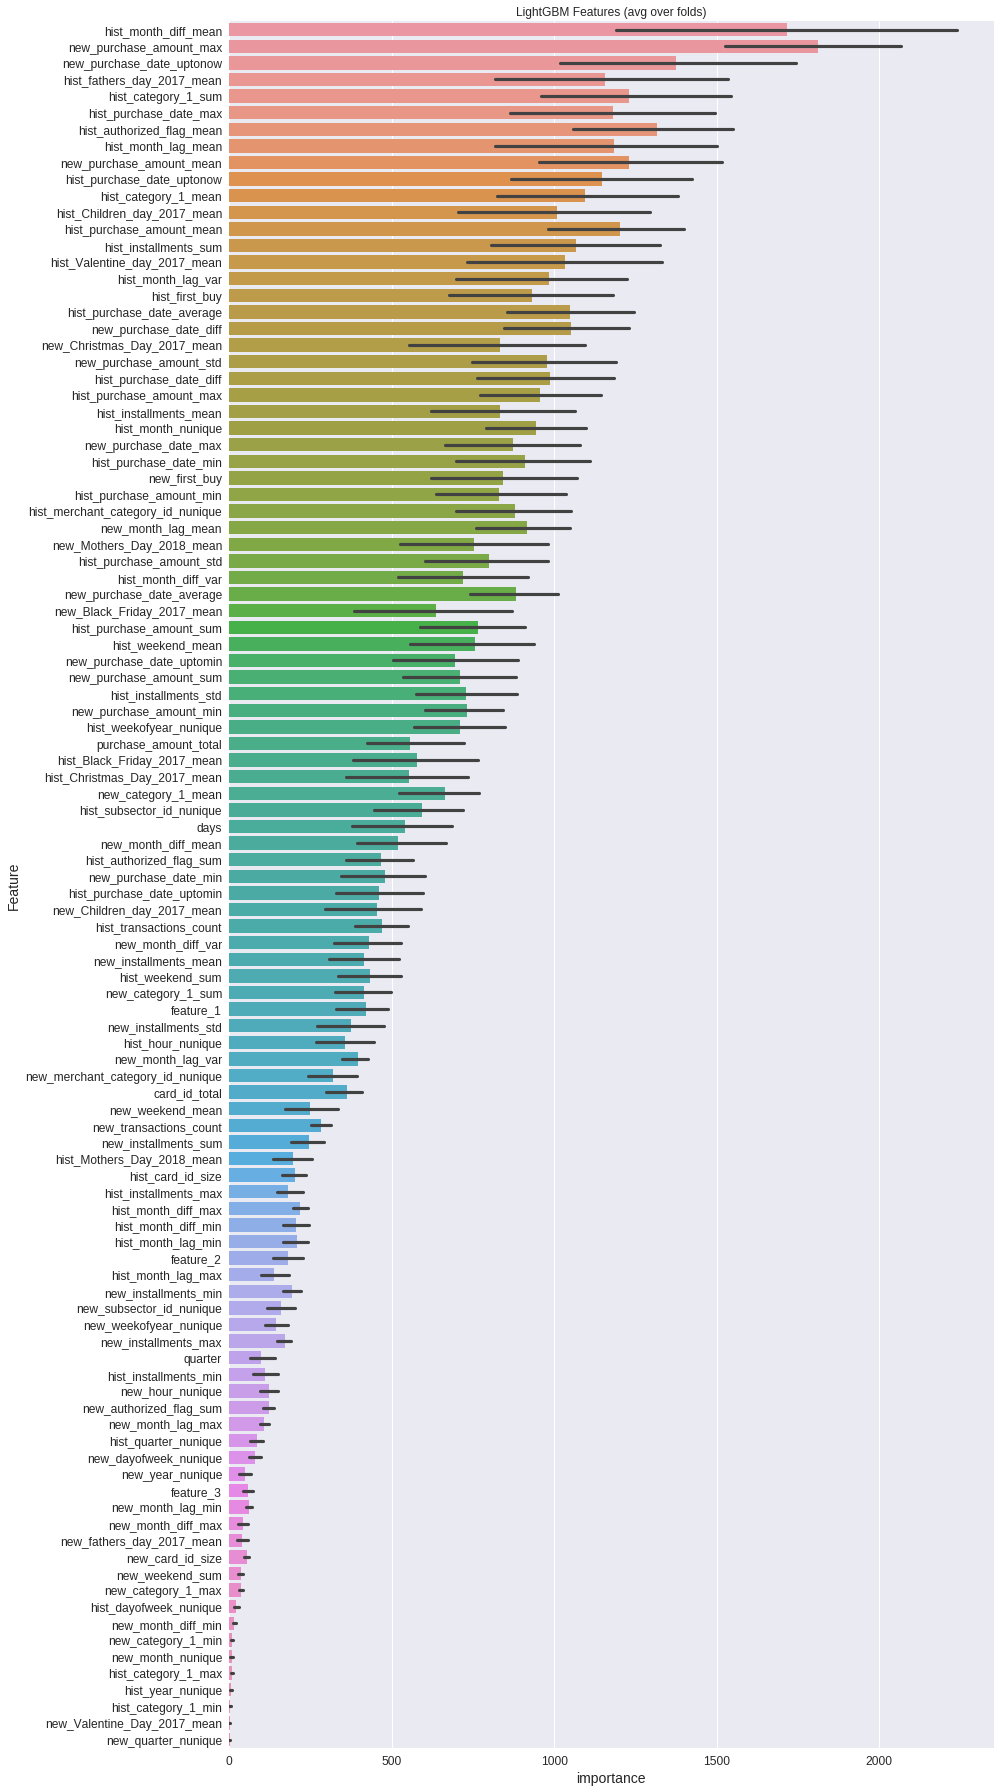

In [34]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="Feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

Final Predictions and Submission File.

In [35]:
sample_submission = pd.read_csv('../input/sample_submission.csv')
sample_submission['target'] = predictions
sample_submission.to_csv('submission_ashish_lgbm.csv', index=False)